In [125]:
import pandas as pd
import random
import numpy as np

In [126]:
data = pd.read_csv('cleaned_data.csv')

In [127]:
data.columns

Index(['Unnamed: 0', 'track id', 'Genre', ' amazement', ' solemnity',
       ' tenderness', ' nostalgia', ' calmness', ' power',
       ' joyful_activation', ' tension', ' sadness', ' mood', ' liked',
       ' disliked', ' age', ' gender', ' mother tongue', 'merge_key', 'Title',
       'Artist', 'Key', 'BPM', 'file_id'],
      dtype='object')

In [128]:
data = data.drop(['Unnamed: 0', 'track id', ' liked', ' disliked', ' gender', ' mother tongue', 'merge_key', 'Title',
       'Artist','file_id'], axis=1)

In [129]:
genres = ['Pop', 'Rock', 'Jazz', 'Classical', 'Electronic', 'Hip-hop'] 
bpm_range = (60, 200)
listening_frequencies = ['hourly', 'daily', 'weekly', 'monthly']

data['avg_bpm_listened'] = [random.randint(bpm_range[0], bpm_range[1]) for _ in range(len(data))]
data['most_listened_genre'] = [random.choice(genres) for _ in range(len(data))]
data['listening_frequency'] = [random.choice(listening_frequencies) for _ in range(len(data))]

In [130]:
data.rename(columns={' amazement':'amazement', 
                     ' solemnity':'solemnity', 
                     ' tenderness':'tenderness', 
                     ' nostalgia':'nostalgia',
                     ' calmness':'calmness', 
                     ' power': 'power', 
                     ' joyful_activation':'joyful_activation', 
                     ' tension':'tension', 
                     ' sadness':'sadness',
                     ' mood':'mood', 
                     ' age':'age'}, inplace=True)

#### Things we want to request from the user [model input]:
1) Current mood (rate from 1 (very bad) to 5 (very good)):’mood'
2) mood after listening to song. Choose from the following: 'amazement', 'solemnity', 'tenderness', 'nostalgia', 'calmness', 'power', 'joyful_activation', 'tension', 'sadness'
3) Age of user:’ age'

##### Things to extract from user listening history:
4) 'avg_bpm_listened'
5) 'most_listened_genre'
6) 'listening_frequency' choose from (hourly, daily, weekly, monthly)

#### Generate a song based on [model output]: 
1) 'Genre' 
2) 'Key' 
3) 'BPM'

In [131]:
input_vector_columns = [
    'amazement', 'solemnity', 'tenderness', 'nostalgia', 'calmness', 'power',
    'joyful_activation', 'tension', 'sadness', 'mood', 'age', 
    'avg_bpm_listened', 'most_listened_genre', 'listening_frequency'
]

target_vector_columns = ['Genre', 'Key', 'BPM']

# Split the dataframe
input_vector = data[input_vector_columns]
target_vector = data[target_vector_columns]

In [132]:
input_vector_encoded = pd.get_dummies(input_vector, columns=['most_listened_genre', 'listening_frequency'])
target_vector_encoded = pd.get_dummies(target_vector, columns=['Genre', 'Key'])

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)  
        self.fc2 = nn.Linear(16, 8)          
        self.fc3 = nn.Linear(8, 4)           
        self.fc4 = nn.Linear(4, output_size)  

    def forward(self, x):
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = F.relu(self.fc3(x))  
        x = self.fc4(x)          
        return x


# Initialize the model
model = NeuralNetwork(input_vector_encoded.shape[1], target_vector_encoded.shape[1])
model

NeuralNetwork(
  (fc1): Linear(in_features=22, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=29, bias=True)
)

In [134]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler


input_data_continuous = input_vector_encoded[['mood', 'age', 'avg_bpm_listened']].copy()

scaler = MinMaxScaler()
input_data_scaled = scaler.fit_transform(input_data_continuous)

input_vector_encoded[['mood', 'age', 'avg_bpm_listened']] = input_data_scaled

BPM_data = target_vector_encoded[['BPM']].copy()

scaler_target = MinMaxScaler()
BPM_scaled = scaler_target.fit_transform(BPM_data)

target_vector_encoded['BPM'] = BPM_scaled

# Convert dataframes to PyTorch tensors
X = torch.tensor(input_vector_encoded.values, dtype=torch.float32)
y = torch.tensor(target_vector_encoded.values, dtype=torch.float32)

# Split data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader for training and validation sets
batch_size = 128
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

len(train_loader), len(val_loader)

(51, 13)

In [157]:
# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [158]:
def train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs=50):
    # Store the losses for plotting
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Training step
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()

        # Calculate the average loss for this epoch
        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)

        # Validation step
        model.eval()  # Set the model to evaluation mode
        running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item()

        average_val_loss = running_loss / len(val_loader)
        val_losses.append(average_val_loss)

        # Print some information after each epoch
        if epoch % 10 == 0:  # Optional: Choose to print less frequently, e.g., every 10 epochs
            print(f"\nEpoch {epoch}/{epochs}")
            print(f"Training Loss: {average_train_loss:.4f}")
            print(f"Validation Loss: {average_val_loss:.4f}")

    return train_losses, val_losses


Epoch 0/50
Training Loss: 6.8917
Validation Loss: 6.8719

Epoch 10/50
Training Loss: 6.8808
Validation Loss: 6.8739

Epoch 20/50
Training Loss: 6.8838
Validation Loss: 6.8749

Epoch 30/50
Training Loss: 6.8811
Validation Loss: 6.8795

Epoch 40/50
Training Loss: 6.8861
Validation Loss: 6.8782


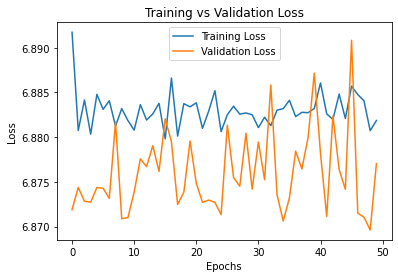

In [159]:
train_losses, val_losses = train_and_validate(model, criterion, optimizer, train_loader, val_loader, epochs=50)

plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [138]:
model.eval()

single_batch = next(iter(val_loader))
inputs, targets = single_batch


with torch.no_grad():
    outputs = model(inputs)

predicted_values = outputs.numpy()  

print(predicted_values)

actual_values = targets.numpy()
print("Actual values:")
print(actual_values)


[[ 1.6186922   1.2899156   1.6190579  ... -0.7340034   0.26891518
  -0.9430026 ]
 [ 1.6480289   1.6283407   0.28674948 ... -1.0576477   0.6033808
  -0.72829914]
 [ 1.6249647   1.2185965   1.4347007  ... -0.7902067   0.343651
  -0.88806   ]
 ...
 [ 1.6625849   0.59500945  0.4660074  ... -1.1095746   0.79627687
  -0.5462213 ]
 [ 1.6565847   0.9779572   0.42219758 ... -1.0842799   0.7177274
  -0.6185714 ]
 [ 1.6291378   1.8147557   0.8618267  ... -0.8858141   0.37893587
  -0.8919846 ]]
Actual values:
[[0.2866242  1.         0.         ... 1.         0.         0.        ]
 [0.49044585 0.         1.         ... 0.         0.         0.        ]
 [0.6369427  0.         0.         ... 0.         1.         0.        ]
 ...
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.49044585 0.         1.         ... 0.         0.         0.        ]
 [0.2356688  0.         0.         ... 0.         0.         0.        ]]


In [139]:
def decode_predictions(predictions, target_vector_encoded):
    """
    Decodes the output of the neural network model from one-hot encoded arrays to a readable dictionary format.

    :param predictions: Numpy array of model predictions.
    :param input_vector_encoded: DataFrame of the encoded input features.
    :param target_vector_encoded: DataFrame of the encoded target features.
    :return: A dictionary containing readable model predictions.
    """
    # Initialize a dictionary to hold the decoded results
    decoded_results = {
        'Genre': '',
        'Key': '',
        'BPM': 0
    }

    # Get the list of encoded columns for Genre and Key
    genre_cols = [col for col in target_vector_encoded if col.startswith('Genre_')]
    key_cols = [col for col in target_vector_encoded if col.startswith('Key_')]

    # Extract the portions of the prediction associated with Genre and Key
    genre_predictions = predictions[0, [target_vector_encoded.columns.get_loc(col) for col in genre_cols]]
    key_predictions = predictions[0, [target_vector_encoded.columns.get_loc(col) for col in key_cols]]

    # Identify the index of the highest probability in each category, which represents the model's prediction
    predicted_genre = genre_cols[np.argmax(genre_predictions)].split('_', 1)[1]  # Extracting the actual genre
    predicted_key = key_cols[np.argmax(key_predictions)].split('_', 1)[1]  # Extracting the actual key

    # Since BPM is a numerical value, directly use the corresponding prediction
    # Assuming the BPM is at a fixed index in your output layer - adjust if different
    bpm_index = target_vector_encoded.columns.get_loc('BPM')
    predicted_bpm = predictions[0, bpm_index]  # You might want to round this value if necessary

    # Update the results dictionary
    decoded_results['Genre'] = predicted_genre
    decoded_results['Key'] = predicted_key
    decoded_results['BPM'] = int(round(predicted_bpm)) 

    return decoded_results


In [140]:
decode_predictions(predicted_value, target_vector_encoded)

{'Genre': 'classical', 'Key': 'G Major', 'BPM': 107}

In [141]:
decode_predictions(single_target.numpy(), target_vector_encoded)

{'Genre': 'classical', 'Key': 'D♭ Major', 'BPM': 78}

In [142]:
def decode_predictions(predictions, target_vector_encoded):
    """
    Decodes the output of the neural network model from one-hot encoded arrays to a readable dictionary format.

    :param predictions: Numpy array of model predictions (1-dimensional).
    :param input_vector_encoded: DataFrame of the encoded input features.
    :param target_vector_encoded: DataFrame of the encoded target features.
    :return: A dictionary containing readable model predictions.
    """
    # Initialize a dictionary to hold the decoded results
    decoded_results = {
        'Genre': '',
        'Key': '',
        'BPM': 0
    }

    # Get the list of encoded columns for Genre and Key
    genre_cols = [col for col in target_vector_encoded if col.startswith('Genre_')]
    key_cols = [col for col in target_vector_encoded if col.startswith('Key_')]

    # Adjust the indexing since 'predictions' is 1-dimensional
    genre_predictions = predictions[[target_vector_encoded.columns.get_loc(col) for col in genre_cols]]
    key_predictions = predictions[[target_vector_encoded.columns.get_loc(col) for col in key_cols]]

    # Identify the index of the highest probability in each category, which represents the model's prediction
    predicted_genre = genre_cols[np.argmax(genre_predictions)].split('_', 1)[1]  # Extracting the actual genre
    predicted_key = key_cols[np.argmax(key_predictions)].split('_', 1)[1]  # Extracting the actual key

    # For BPM, directly use the corresponding prediction (assuming the BPM is at a fixed index in your output layer)
    bpm_index = target_vector_encoded.columns.get_loc('BPM')
    predicted_bpm = predictions[bpm_index]  # You might want to round this value if necessary

    # Update the results dictionary
    decoded_results['Genre'] = predicted_genre
    decoded_results['Key'] = predicted_key
    decoded_results['BPM'] = int(round(predicted_bpm))  # Convert to an integer after rounding

    return decoded_results


In [143]:
# Assume 'inputs' and 'targets' are obtained from your validation loader

# 1. Run the model to get predictions
with torch.no_grad():
    predictions = model(inputs)  # Forward pass

# Convert the tensors to numpy arrays for easy manipulation
predictions_np = predictions.numpy()
targets_np = targets.numpy()  # Assuming 'targets' are the correct labels for your inputs

# Initialize lists to hold decoded results
decoded_predictions_list = []
decoded_actuals_list = []

# 2 and 3. Decode each prediction and the corresponding actual target
for i in range(len(predictions_np)):
    decoded_prediction = decode_predictions(predictions_np[i], target_vector_encoded)
    decoded_actual = decode_predictions(targets_np[i], target_vector_encoded)
    
    decoded_predictions_list.append(decoded_prediction)
    decoded_actuals_list.append(decoded_actual)

# 4. Print out or compare the actual vs predicted values
for i in range(len(decoded_predictions_list)):
    print(f"Record {i+1}:")
    print(f"Actual: {decoded_actuals_list[i]}")
    print(f"Predicted: {decoded_predictions_list[i]}")
    print("-" * 30)  # Just for a clean separation

# Optionally, you could further analyze the results (like calculating the accuracy, etc.)


Record 1:
Actual: {'Genre': 'classical', 'Key': 'F♯ Minor', 'BPM': 0}
Predicted: {'Genre': 'electronic', 'Key': 'G Major', 'BPM': 2}
------------------------------
Record 2:
Actual: {'Genre': 'electronic', 'Key': 'B♭ Minor', 'BPM': 0}
Predicted: {'Genre': 'classical', 'Key': 'G Major', 'BPM': 2}
------------------------------
Record 3:
Actual: {'Genre': 'rock', 'Key': 'G Major', 'BPM': 1}
Predicted: {'Genre': 'electronic', 'Key': 'G Major', 'BPM': 2}
------------------------------
Record 4:
Actual: {'Genre': 'classical', 'Key': 'B Major', 'BPM': 0}
Predicted: {'Genre': 'classical', 'Key': 'G Major', 'BPM': 2}
------------------------------
Record 5:
Actual: {'Genre': 'electronic', 'Key': 'E Minor', 'BPM': 0}
Predicted: {'Genre': 'classical', 'Key': 'G Major', 'BPM': 2}
------------------------------
Record 6:
Actual: {'Genre': 'classical', 'Key': 'D♭ Major', 'BPM': 0}
Predicted: {'Genre': 'classical', 'Key': 'G Major', 'BPM': 2}
------------------------------
Record 7:
Actual: {'Genre'